### Ragas is a framework that helps you evaluate your Retrieval Augmented Generation (RAG) pipelines


In [2]:
#!pip install openai==0.28.1
#!pip install openai --upgrade
#!pip install ragas
#!pip install unstructured
#!pip install langchain[all]
#!pip install --upgrade langchain

#!pip install playwright
#!pip install -U selenium unstructured
#!pip install --upgrade langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

In [1]:
#!pip install pydantic==2.5
#!pip install --upgrade --quiet  langchain_milvus
#!pip install --upgrade scipy

In [4]:
import os, json
import openai
#from langchain.chat_models import ChatOpenAI, ChatGooglePalm
from utils import OPENAI_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY 
#os.environ["LANGCHAIN_TRACING_V2"] = "true"

#openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
import bs4
#from langchain import hub
from langchain_community.document_loaders import SeleniumURLLoader, TextLoader
#from langchain_chroma import Chroma
from langchain_milvus.vectorstores import Milvus
#from langchain_core.output_parsers import StrOutputParser
#from langchain_core.runnables import RunnablePassthrough
#from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter, NLTKTextSplitter
#from langchain.storage import InMemoryStore
#from langchain.retrievers import ParentDocumentRetriever

#from langchain.chains import create_history_aware_retriever, create_retrieval_chain
#from langchain.chains.combine_documents import create_stuff_documents_chain
#from langchain_community.chat_message_histories import ChatMessageHistory
#from langchain_core.chat_history import BaseChatMessageHistory
#from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
#from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


In [5]:
ai_model = "gpt-3.5-turbo-0125"
tokens = 1000

llm = ChatOpenAI(model=ai_model, temperature=0.)

AttributeError: module 'openai' has no attribute 'OpenAI'

In [7]:
def load_url_documets(list_urls):
    
    # Load, chunk and index the contents of the blog.
    loader_url =SeleniumURLLoader( list_urls)
    docs = loader_url.load()
    #text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n","\n"], chunk_size=500, chunk_overlap=50)
    text_splitter = NLTKTextSplitter(chunk_size=tokens, chunk_overlap=50)
    splits = text_splitter.split_documents(docs)
    
    return splits, docs


def question2chunk(
                chunk, 
                llm=ChatOpenAI(model=ai_model, temperature=0.2)
                ):
    """
    Use the language model to create a question for a chunks
    """
    
    SYSTEM_PROMPT = """
      Human: You are an AI assistant , an expert in machine learning and the quantum physics. 
      """
    USER_PROMPT = f"""
      Read the following chunk of a text enclosed in ###context tag ,  and write a question for that chunk, 
      on which the chunk of text gives an answer.
    
      ###context
      {chunk.page_content}

      """
    return llm.invoke([
           {"role": "system", "content": SYSTEM_PROMPT},
           {"role": "user", "content": USER_PROMPT},
           ]).content



def get_questioins(path):
    """
    Read a file with questions
    """
    loader = TextLoader(path)
    docs = loader.load()
    texts = docs[0].page_content.split('\n')
    questions = []
    for q in  texts:
        if "?" in q:
            questions.append(q)
    return questions

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)



### Load docuements

In [8]:
url_list = ["https://www.nature.com/articles/s41524-023-01062-z",
            "https://www.nature.com/articles/s41699-023-00369-1",
            "https://github.com/HSE-LAMBDA/ai4material_design/tree/main/docs/CONSTRUCTOR-MOCK.md"
            "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/CONSTRUCTOR.md",
            "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/DATA.md",
            "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/ENVIRONMENT.md",
            "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/GENERATING-CONSTRUCTOR.md",
            "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/GENERATING-MOCK.md",
            "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/PILOT.md",
            "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/SPARSE-PAPER.md"
          #  "https://www.nature.com/articles/s41377-024-01407-3",
          #  "https://www.nature.com/articles/s41565-023-01407-1",
          #  "https://www.nature.com/articles/s41699-023-00369-1",
           ]
                               
chunks, documents = load_url_documets(url_list)
print(len(chunks), len(documents))

Created a chunk of size 1063, which is longer than the specified 1000
Created a chunk of size 1304, which is longer than the specified 1000
Created a chunk of size 1227, which is longer than the specified 1000
Created a chunk of size 2175, which is longer than the specified 1000
Created a chunk of size 2042, which is longer than the specified 1000


139 9


### Get embedinng of a chunk or a question for the chunk.

In [9]:
def get_embs(
    chunks, # list of  chunks
    embedding=OpenAIEmbeddings(), # embbeding model
    question=True, # if True, use the question2chunk function  to generate questions for chunks
    verbose=False # if True, Show generated qeustions for chuncks
    ):
    """
    Get embeddings for a list of chunks
    if question is True gives a list of queations embeddings else  a list of chunks embeddings
    """
     
    q_list = [question2chunk(t) for t in chunks] if question else [t.page_content for t in chunks]
    emb = embedding.embed_documents(q_list)
    
    # Show generated qeustions for chuncks
    if  verbose:
        n = 1
        for  q, c in zip(q_list, chunks):
            print("#N", n)
            print(q)
            print()
            print(c.page_content)
            print("*"*10)
            n +=1
            
    return emb,  q_list

In [10]:
emb, q_list = get_embs(chunks, embedding=OpenAIEmbeddings(), verbose=True)   

#N 1
What is the focus of the research discussed in the article "Sparse representation for machine learning the properties of defects in 2D materials"?

Sparse representation for machine learning the properties of defects in 2D materials

Download PDF

Download PDF

Article

Open access

Published: 26 June 2023

Sparse representation for machine learning the properties of defects in 2D materials

Nikita Kazeev 
            ORCID: orcid.org/0000-0002-5699-76341,2 na1,

Abdalaziz Rashid Al-Maeeni 
            ORCID: orcid.org/0000-0002-3299-72933 na1,

Ignat Romanov 
            ORCID: orcid.org/0009-0005-1149-80803,

Maxim Faleev4,

Ruslan Lukin4,

Alexander Tormasov 
            ORCID: orcid.org/0000-0001-6887-43274,

A. H. Castro Neto1,5,

Kostya S. Novoselov1,

Pengru Huang 
            ORCID: orcid.org/0000-0001-7863-80451 &

…

Andrey Ustyuzhanin1,2

Show authors

npj Computational Materials

                        volume 9, Article number: 113 (2023)
            Cite this article

### Plot the embeddins.

In [11]:
from torch import nn

import torch 

In [12]:
print(torch.tensor(emb).shape)

torch.Size([139, 1536])


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 139 samples in 0.001s...
[t-SNE] Computed neighbors for 139 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 139 / 139
[t-SNE] Mean sigma: 0.214036
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.870667
[t-SNE] KL divergence after 300 iterations: 0.500802


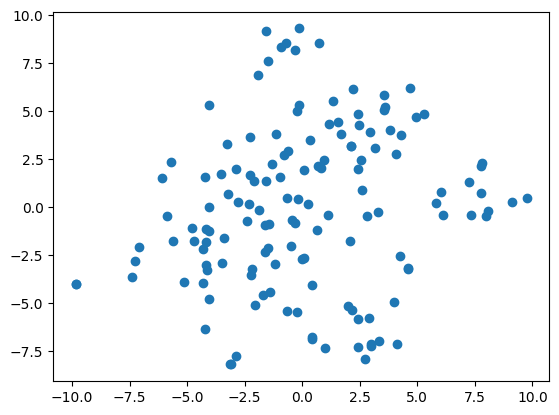

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.array(emb))

tsne_results = tsne_results.transpose()

plt.scatter(tsne_results[0], tsne_results[1])
plt.title("2D TSNE Question and Chunk Embeddings")
plt.legend(["Questions", "Chunks"])
plt.show()


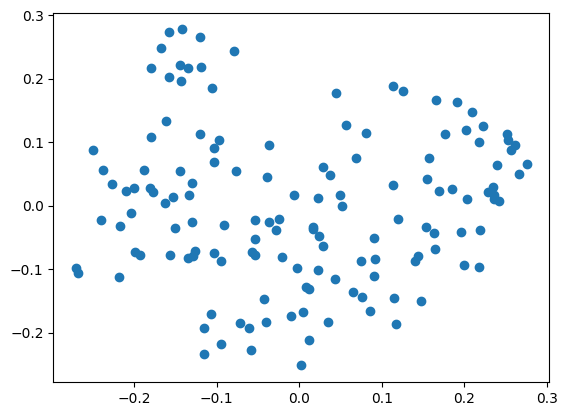

In [14]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(emb)


t = reduced.transpose()

plt.scatter(t[0], t[1])
plt.title("2D PCA Question and Chunk Embeddings")
plt.legend(["Questions", "Chunks"])
plt.show()

### 1. Create MilVus  index.

In [15]:
from tqdm import tqdm
from pymilvus import MilvusClient

milvus_client = MilvusClient("./milvus_demo.db")

collection_name = "my_rag_question_collection_ai4mat"

In [16]:
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=len(emb[0]),
    metric_type="IP",  # Inner product distance
    consistency_level="Strong",  # Strong consistency level
    )

In [17]:


data = []

for i, line in enumerate(tqdm(chunks, desc="Creating embeddings")):
    data.append({"id": i, "vector": emb[i], "text": chunks[i].page_content, "question": q_list[i]})

milvus_client.insert(collection_name=collection_name, data=data)


Creating embeddings: 100%|████████████████| 139/139 [00:00<00:00, 260620.59it/s]


{'insert_count': 139,
 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138],
 'cost': 0}

### 2. Create a retriever. 
#### Create context from the milvus index.

In [18]:
def get_context(
                question, 
                vecstore, 
                collection_name, 
                embedding=OpenAIEmbeddings(), 
                top_k=10,
                verbose=False,
               ):

    search_res = vecstore.search(
         collection_name=collection_name,
         data=[
              embedding.embed_query(question)
              ],  # Use the `emb_text` function to convert the question to an embedding vector
         limit=top_k,  # Return top k results
         search_params={"metric_type": "IP", "params": {}},  # Inner product distance
         output_fields=["text"],  # Return the text field
             )

    retrieved_lines_with_distances = [
    (res["entity"]["text"], res["distance"]) for res in search_res[0]
                                     ]
    if verbose:
        print("Retrieved lines with distances:")
        for line, distance in retrieved_lines_with_distances:
            print(f"- {line}")
            print(f"  Distance: {distance}")
            print()
         
    
    #context = "\n".join(
    #[line for (line, dist) in retrieved_lines_with_distances]
    #      )
    
    context = [line for (line, dist) in retrieved_lines_with_distances]
    
    
    return context

### 3. Create a function that returns the answer to a question based on the context

In [19]:
from langchain.chains.llm import LLMChain
from langchain_core.prompts import PromptTemplate

def get_ideal_answer(question, context, llm=llm):
    
    '''
    Get an ideal answer summarizing the context  for  a given question
    '''

    # Define prompt
    prompt_template = """
       You are an AI assistant for machine learning, quantum physics and  structure of materials.
       Write a concise summary of the following:
       "{text}"
       by answering on a 
       "{question}"
    
       If you think that there is no an answer on the question, just say that you don't know.
    
       CONCISE SUMMARY:
       """
    prompt = PromptTemplate.from_template(prompt_template)
    llm_chain = LLMChain(llm=llm, prompt=prompt)

    return llm_chain.invoke({"text": context,
                  "question": question
                 })['text']

####  Get questions.

In [20]:
from langchain.document_loaders import TextLoader
ques = get_questioins("data/data_rag/Sparse representation - questions.txt")

#### Get answers for  questions.

In [21]:
qa_dict = {}
verbose = False # if True, Show context for each question.

for q in ques:
    if verbose: print(q)
    context = get_context(q, milvus_client, collection_name, verbose=verbose)
    if verbose: print(context)
    answer = get_ideal_answer(q, context)
    qa_dict[q] = answer
    if verbose: print()

#### Print questions : answers.

In [22]:
l_answer, l_question = [], []

for k,v in qa_dict.items():
    print(k)
    print()
    print(v)
    print("**********************************")
    print()
    l_answer.append(v)
    l_question.append(k)
        

* Which materials are in the dataset?

The dataset includes 2D materials such as MoS2, WSe2, hexagonal boron nitride (h-BN), GaSe, InSe, and black phosphorous.
**********************************

* How many structures are there in the dataset?

The dataset contains a total of 14,866 structures with 120-192 atoms each.
**********************************

* How to obtain the dataset?

The dataset can be obtained by downloading the archive directly from the Constructor Research Platform or by using DVC to clone the repository and pull the datasets. The data is available in CSV format with various descriptors and energy values for defect structures.
**********************************

* What is the dataset license?

The dataset is licensed under a Creative Commons Attribution 4.0 International License, allowing for use, sharing, adaptation, distribution, and reproduction as long as appropriate credit is given to the original author(s) and source.
**********************************

* What 

### Save results.

In [23]:
name = f"9doc&MILVUS_RAGtop10_QA_question_context_{ai_model}_{tokens}ts"
with open(f'data/data_rag/qa_dict_{name}.json', 'w') as fp:
    json.dump(qa_dict, fp)

In [24]:
import pandas as pd

df = pd.DataFrame()
df['question'] = l_question
#df['Content'] = doc_url[0].metadata['description']
df['answer'] = l_answer
#df['number of documets'] = len(documents)
#for i in range(len(documents)):
    #df[f'Content_{i}'] = documents[i].metadata['description']
    #df[f'Titles_{i}'] = documents[i].metadata['title']
    #df[f'Urls_{i}'] = documents[i].metadata['source']

df.to_csv(f"data/data_rag/qa_dict_{name}.csv", index=False)

#### Compare with old way.

In [25]:

df_old = pd.read_csv(f"data/data_rag/qa_dict_9doc&MILVUS_RAGtop10_QA_question_context_gpt-3.5-turbo.csv")

In [26]:
df['old_answer'] = df_old['answer_Qemb']

In [27]:
df

,question,answer,old_answer
0,* Which materials are in the dataset?,The dataset includes 2D materials such as MoS2...,"The materials in the dataset are MoS2, WSe2, h..."
1,* How many structures are there in the dataset?,"The dataset contains a total of 14,866 structu...",I don't know the answer to that question based...
2,* How to obtain the dataset?,The dataset can be obtained by downloading the...,"To obtain the dataset, you can download it fro..."
3,* What is the dataset license?,The dataset is licensed under a Creative Commo...,The dataset license is a Creative Commons Attr...
4,* What is the data format?,"The data format provided is in CSV format, spe...",The data format provided in the context snippe...
5,* How to read the dataset?,The dataset consists of two parts: low defect ...,I don't have the specific information on how t...
6,* How to browse the dataset?,The dataset can be downloaded from the Constru...,I don't know.
7,* Can I work with the dataset without Python?,The provided text contains instructions for ru...,I don't have enough information to answer whet...
8,* How to obtain the raw VASP files?,"To obtain the raw VASP files, you need to clon...","To obtain the raw VASP files, you can follow t..."
9,* What were the settings used for the DFT comp...,The DFT computations were based on density fun...,The settings used for the DFT computations inc...


In [28]:
df.to_csv(f"data/data_rag/qa_dict_{name}.csv", index=False)